## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle

import os

from collections import Counter

from keras.applications.vgg16 import VGG16  # Pre-trained model
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import np_utils
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# To display images
from PIL import Image
from IPython.display import display

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To cteate t-SNE graphs
from sklearn.manifold import TSNE

from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Using TensorFlow backend.


In [2]:
# Dataframe where text has been formatted correctly
# Use for tokenization
with open('products_data', 'rb') as picklefile: 
    df, input_index = pickle.load(picklefile)

# Function Definitions

## Function to calculate image similarity (for test purposes)

In [3]:
# Print cosine similarity for the input images
# Print the product details for both images
def test_similarity(img0, img1):
    print(float(cosine_similarity(prediction_array[img0].reshape(1,-1), prediction_array[img1].reshape(1,-1))))
    print('\n', df.iloc[img0], '\n\n', df.iloc[img1])

## Function to make items in DataFrame clickable

In [4]:
# Input is the string url+name and turns it into a hyperlink
# Output is a link where the visible name is the product name, 
# and the hyperlink is the product link
def make_clickable_both(val): 
    name, url = val.split('###') 
    return f'<a href="{url}">{name}</a>'

# Analysis

## Get Image Similarities

In [5]:
# Initialize model
# Exclude the final dense layers by setting include_top=False
# Input images need to be 224x224 with 3 color channels (RGB) 
model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 

In [6]:
model.layers

In [7]:
# Loading all the images as a np array
# The images have to be in a subdirectory, i.e. they're in pwd/data/data
# shuffle=False to keep images in correct number order
# The target_size is (224,224) so they fit into the input_shape of the VGG16 model
# The target_size resizes our image to 224x224
# We aren't doing classification, so class_mode=None
images_array = ImageDataGenerator().flow_from_directory('data', shuffle=False, target_size=(224,224), class_mode=None)

Found 277 images belonging to 1 classes.


In [8]:
# All the images that are in /data/data
images_array.filenames

['data/000.jpg',
 'data/001.jpg',
 'data/002.jpg',
 'data/003.jpg',
 'data/004.jpg',
 'data/005.jpg',
 'data/006.jpg',
 'data/007.jpg',
 'data/008.jpg',
 'data/009.jpg',
 'data/010.jpg',
 'data/011.jpg',
 'data/012.jpg',
 'data/013.jpg',
 'data/014.jpg',
 'data/015.jpg',
 'data/016.jpg',
 'data/017.jpg',
 'data/018.jpg',
 'data/019.jpg',
 'data/020.jpg',
 'data/021.jpg',
 'data/022.jpg',
 'data/023.jpg',
 'data/024.jpg',
 'data/025.jpg',
 'data/026.jpg',
 'data/027.jpg',
 'data/028.jpg',
 'data/029.jpg',
 'data/030.jpg',
 'data/031.jpg',
 'data/032.jpg',
 'data/033.jpg',
 'data/034.jpg',
 'data/035.jpg',
 'data/036.jpg',
 'data/037.jpg',
 'data/038.jpg',
 'data/039.jpg',
 'data/040.jpg',
 'data/041.jpg',
 'data/042.jpg',
 'data/043.jpg',
 'data/044.jpg',
 'data/045.jpg',
 'data/046.jpg',
 'data/047.jpg',
 'data/048.jpg',
 'data/049.jpg',
 'data/050.jpg',
 'data/051.jpg',
 'data/052.jpg',
 'data/053.jpg',
 'data/054.jpg',
 'data/055.jpg',
 'data/056.jpg',
 'data/057.jpg',
 'data/058.jpg

In [9]:
# Put array of images thru dissected VGG16 model to obtain array of feature embeddings
# Number of images
num_images = len(images_array.filenames)

# .reshape(num_images,-1) to flatten the images into num_images rows, one for each image
# There are num_images images (rows), and -1 automatically creates the correct number of 
# columns (features)
prediction_array = model.predict_generator(images_array).reshape(num_images,-1)

In [10]:
# The number of rows should = num_images
# Columns represent the features for each image
# Each row is the respective image's prediction
prediction_array.shape

(277, 25088)

In [11]:
# Create similarities column in df
# Each image will containe its cosine similarity to the input_index image
similarities = []

for product in range(num_images):
    similarities.append(float(cosine_similarity(prediction_array[input_index].reshape(1,-1), prediction_array[product].reshape(1,-1))))

# Add similarities column to df
df['similarities'] = similarities

In [12]:
# Create separate df for input image
# Currently unused
# input_image_df = df.iloc[input_index,:]

In [13]:
# Drop input image from original df
# Doing this because we don't want to recommend the product the user inputs
df.drop(input_index, inplace=True)

In [14]:
# Sort by descending similarity value
df.sort_values(by='similarities', ascending=False, inplace=True)

In [15]:
# Prevent displayed data from being truncated
pd.set_option('display.max_colwidth', -1)

In [16]:
# Drop any rows that have np.nan in price or rating
df.dropna(inplace=True, subset=['price', 'rating'])

In [17]:
# Filter down to the number of listings the user wants to see, sorted by $-$$
# The number of visible listings has been manually set to 10 in this notebook
output_df = df.iloc[:10, 1:].sort_values(by='price')

In [18]:
# Create new column which will contain product names, with hyperlinks to product page
output_df['product'] = output_df['name'] + '###' + output_df['url'] 

In [19]:
# Keep only necessary columns
output_df = output_df[['product', 'rating', 'price']]

output_df.rename(columns={'product': 'Product', 'rating': 'Rating', 'price': 'Price'}, inplace=True)

In [20]:
# Output
output_df.style.format({'Product': make_clickable_both}).hide_index()

Product,Rating,Price
2pcs Hc-sr04 Ultrasonic Distance Measuring Sensor Module Good Compatible Arduino UNO Mega R3 Mega2560 Duemilanove Nano Robot,3.8,4.99
LK COKOINO Hc-sr04 Ultrasonic Distance Measuring Sensor Module for Arduino and Jump Wires with XH-2.54 4P Interface,5,4.99
SMAKN Ultrasonic Module Hc-sr04 Distance Sensor for Arduino UNO Mega R3 Mega2560 Duemilanove Nano Robot Xbee Zigbee,3.2,5.2
Pixnor 2pcs Ultrasonic Module Hc-sr04 Distance Measuring Transducer Sensor for Arduino,5,6.57
Ultrasonic Module HC-SR04 Distance Measuring Transducer Sensor Compatible with Arduino by Atomic Market,5,6.99
UPGRADE INDUSTRIES [1x] HY-SRF05 / HC-SR05 Precise Ultrasonic Range Sensor Module for Arduino by UPGRADE INDUSTRIES,5,7.29
UPGRADE INDUSTRIES [1x] US-015 Long Range 700cm Digital Ultrasonic Arduino Distance Sensor Module by UPGRADE INDUSTRIES,2,7.29
Measuring Module Ranging Ultrasonic Distance Sensor for Obstacle Avoidance in Raspberry Pi or Arduino Projects Pack of 2,3,8.53
Makeblock Me Ultrasonic Sensor V3.0,5,12
PING Ultrasonic Distance Sensor,3.8,29.99


## Plot t-SNE Graph

In [21]:
# Plots an image at each x and y location. 
def plotImage(xData, yData, im):
    for x, y in zip(xData, yData):
        bb = Bbox.from_bounds(x,y,1,2)  
        bb2 = TransformedBbox(bb,ax.transData)
        bbox_image = BboxImage(bb2,
                            norm = None,
                            origin=None,
                            clip_on=False)

        bbox_image.set_data(im)
        ax.add_artist(bbox_image)

In [22]:
# Create t-SNE object
tsne = TSNE(metric='cosine')

# Create t-SNE predictions
tsne_predictions = tsne.fit_transform(prediction_array)

In [23]:
# List of 10 closest images to input image
closest = list(df.index)[:10]

# Append the input image's prediction index
closest.append(input_index)

# The predictions for the 10 closest product images, and the
# original image
# Total length is 11
tsne_plot_items = tsne_predictions[closest]

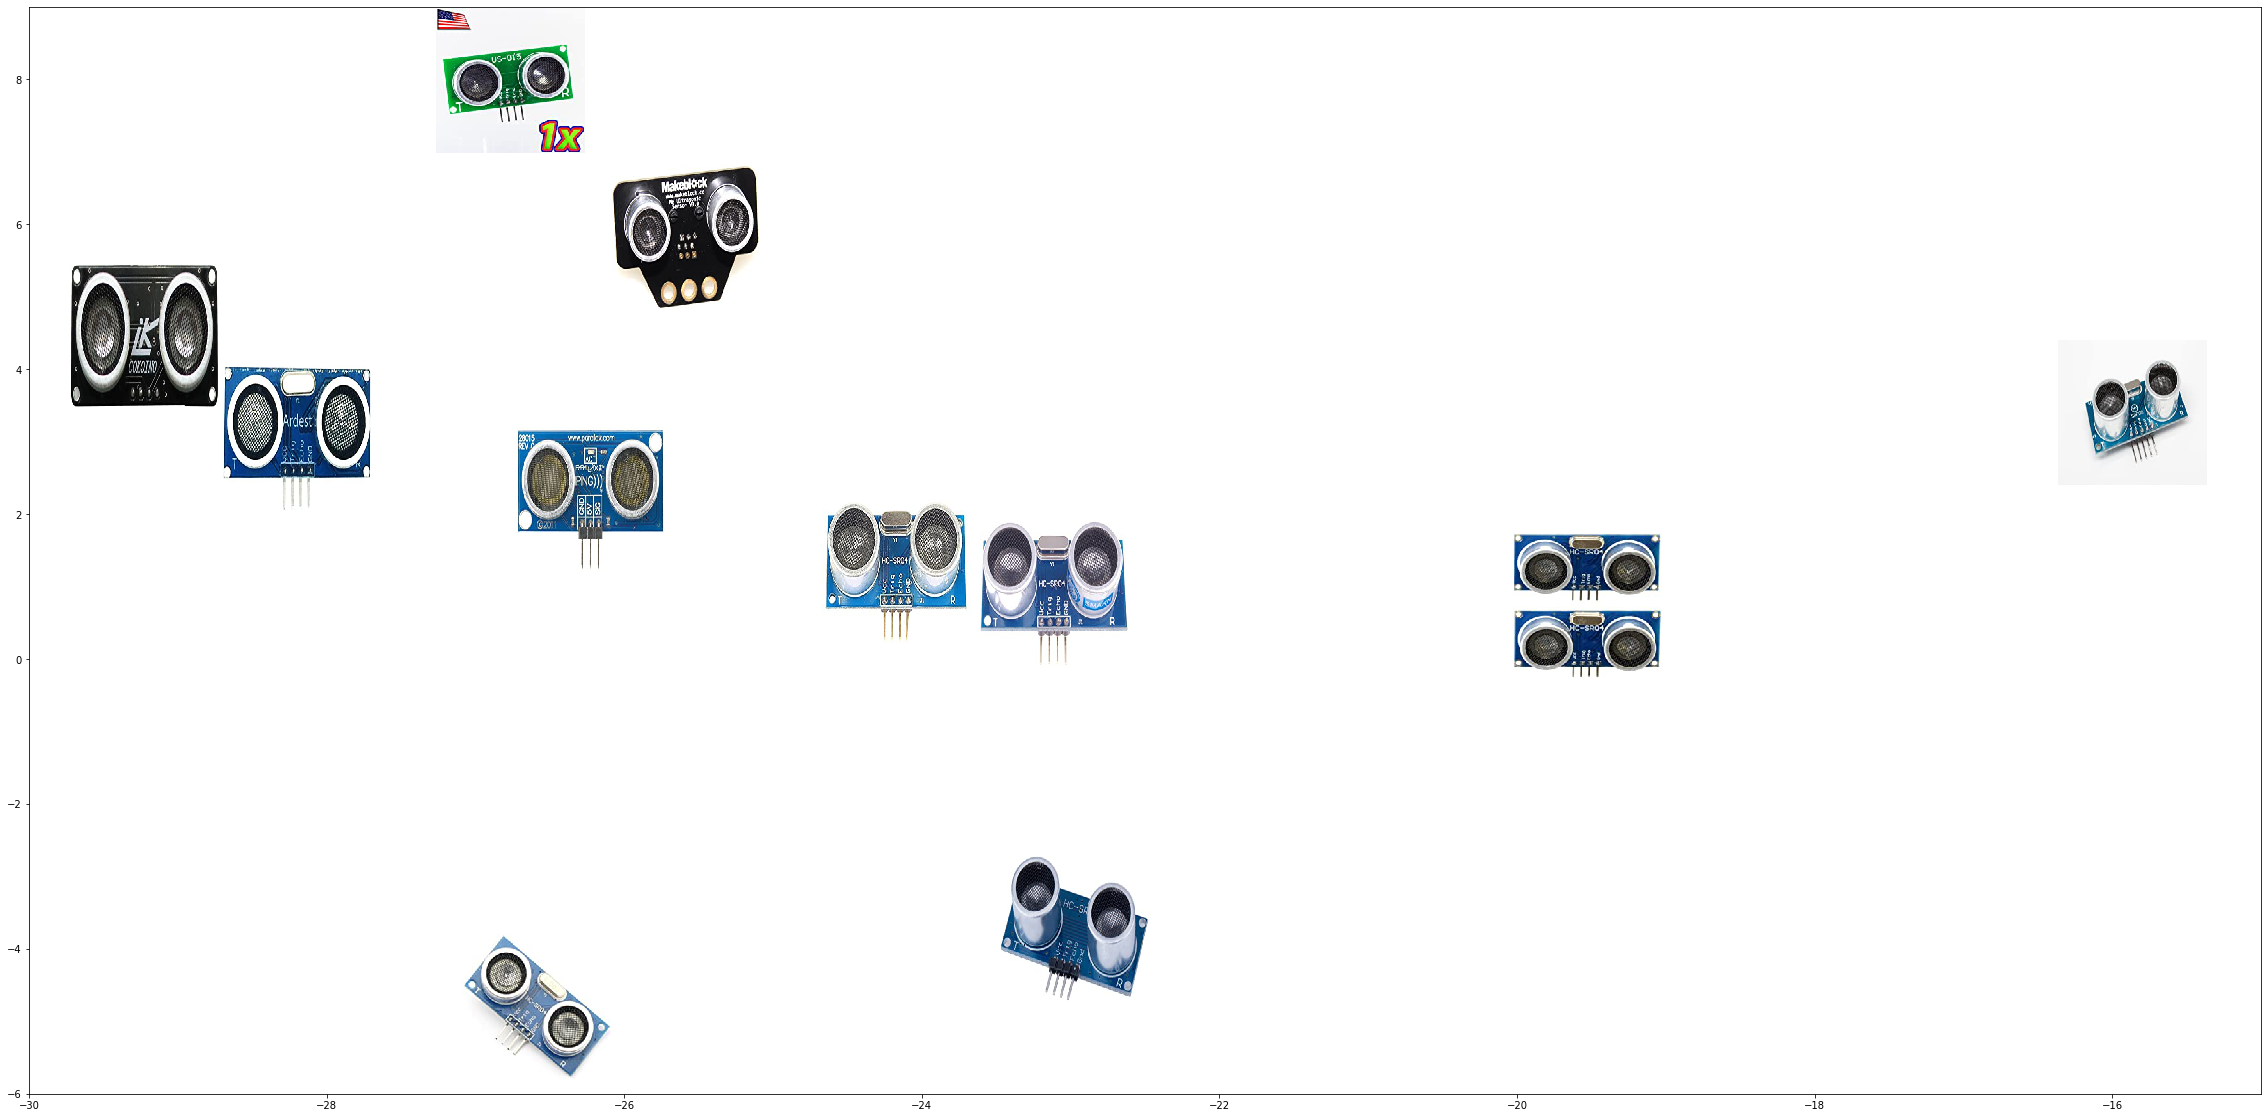

In [36]:
# Create figure
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111)

# Number of digits places. Used for constructing image filename
digits_places = len(str(len(df)))

# Plot all the values in tsne_plot_images, using the respective
# image names from closest
for index, prediction in enumerate(tsne_plot_items):
    # Pad zeros to correctly construct image names
    image_name = str(closest[index]).zfill(digits_places) + '.jpg'
    
    # Plot the image using its respective tsne prediction
    plotImage([prediction[0]], [prediction[1]], plt.imread(os.getcwd() + '/data/data/' + image_name))

# Set the x and y limits
ax.set_ylim(-6,9)
ax.set_xlim(-30,-15)
plt.show()